In [1]:
import numpy as np
import dlib
import cv2
import argparse
import os
from image_utility import save_image, generate_random_color, draw_border
from imutils import face_utils
import copy
import scipy
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt

import mask

%load_ext autoreload
%autoreload 2

In [2]:
#img = 'images/20181024_Biswas_Full_Headshot_zoom_crop.jpg'
#img = 'images/multi_face_1.jpeg'
#img = 'images/suhail_1.jpg'
#img = 'clooney_sym.jpg'
#img = 'images/ryan_2.jpg'
#img = 'IMG_2155.jpg'
#img = 'niv_1.jpg'
#image = cv2.imread(img)

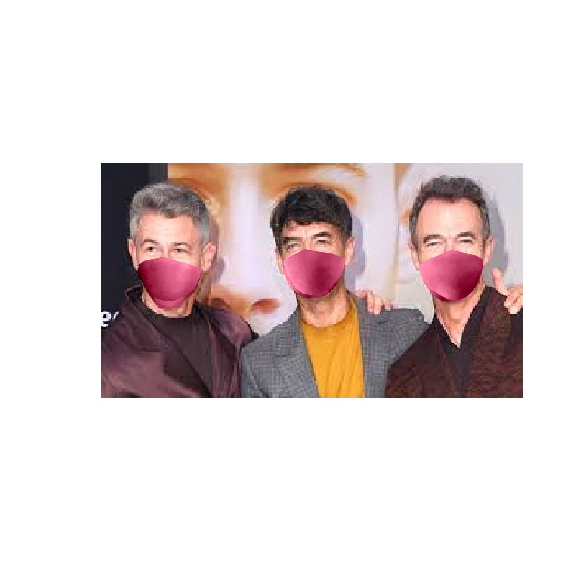

In [3]:
mask.impose_mask(img, img.replace('.jpg', '_mask.jpg'))

## Scratch. Has been moved into mask.py

In [4]:
assert False

AssertionError: 

In [ ]:
WEIGHTS = mask.WEIGHTS
MODEL = mask.MODEL

In [ ]:
face_detector = mask.face_detector

model = MODEL
predictor = mask.predictor

In [ ]:
def add_auxilliary_landmarks(lm):
    right_cheekbone = np.round(0.55*lm[25] + 0.45*lm[11])
    below_right_cheekbone = np.round(0.5*right_cheekbone + 0.5*lm[54])
    left_cheekbone = np.round(0.55*lm[18] + 0.45*lm[5])
    below_left_cheekbone = np.round(0.5*left_cheekbone + 0.5*lm[48])
    right_upper_nostril = np.round(0.7*lm[31] + 0.3*lm[41])
    left_upper_nostril = np.round(0.7*lm[35] + 0.3*lm[46])
    
    inner_jaw_line_1 = 0.75*lm[2:15] + 0.25*lm[30]
    inner_jaw_line_2 = 0.9*lm[2:15] + 0.1*lm[30]
    
    aux_lm = np.vstack([
        lm,
        right_cheekbone,
        below_right_cheekbone,
        left_cheekbone,
        below_left_cheekbone,
        right_upper_nostril,
        left_upper_nostril,
        inner_jaw_line_1,
        inner_jaw_line_2
    ])
    
    return aux_lm

def subset_landmark_points(lm):
    lm_subset = np.vstack([
        lm[2:15,:],
        #lm[0:17,:],
        #lm[28],
        lm[29],
        lm[30],
        lm[31],
        lm[33],
        lm[35],
        lm[48:60],
        lm[68:,:],# all auxiliary points
    ])
    
    # Add random points to improve resolution
    rp = np.random.rand(1000, 2)
    rp[:,0] = rp[:,0]*(np.max(lm[:,0]) - np.min(lm[:,0])) + np.min(lm[:,0])
    rp[:,1] = rp[:,1]*(np.max(lm[:,1]) - np.min(lm[:,1])) + np.min(lm[:,1])
    
    tri = Delaunay(lm_subset)
    mask = tri.find_simplex(rp)>=0
    lm_subset = np.vstack([lm_subset, rp[mask]])
    
    
    return lm_subset

def get_mid_line_eqns(lm):
    # Assumes unaltered landmarks from dlib.
    delta = lm[27] - lm[8]
    m = delta[1]/delta[0]
    b = lm[8][1] - m*lm[8][0]
    
    # orthogonal line, running through middle of face.
    mo = -1/m
    bo = lm[27][1] - mo*lm[27][0]
    
    return m,b,mo,bo

def distance_of_point_to_line(point, m, b):
    # https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    # a = m, b = -1, c = b
    
    return np.abs(m*point[:,0] + (-1)*point[:,1] + b)/(np.sqrt(m**2 + (-1)**2))

In [ ]:
def calculate_delauney_mask_triangles(face_landmarks):
    # face_landmarks = landmark points for a single face.
    
    # Add auxiliary landmark points
    aux_lm = add_auxilliary_landmarks(face_landmarks)
    
    # Subset to those just for the mask.
    # IMPORTANT: everytime this function changes, 
    # like when we update the triangulating points,
    # the semantic centroid dist mat needs to be recomputed.
    sub_aux_lm = subset_landmark_points(aux_lm)
    
    # face midline equations based on all landmarks.
    midline_eqns = get_mid_line_eqns(face_landmarks)
    
    # Delaunay triangulation
    tri = Delaunay(sub_aux_lm)
    tric = sub_aux_lm[tri.simplices] # Triangle coords: num triangles x triangle corners x 2D.
    centroids = np.mean(tric, axis=1)
    
    
    # Compute distance matrices based on distance from
    # vertical and horizontal midline (these should be semantically related)
    # as well as just plain euclidean distance (nearby patches should be similar)
    v_mid_dists = distance_of_point_to_line(centroids, midline_eqns[0], midline_eqns[1])
    h_mid_dists = distance_of_point_to_line(centroids, midline_eqns[2], midline_eqns[3])

    v_pwd = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(v_mid_dists.reshape((-1,1))))
    h_pwd = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(h_mid_dists.reshape((-1,1))))
    pwd = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(centroids))

    # weighted average
    weights = np.array([1,1,0.05])#np.array([1,0.5,0.05]) ## CHANGE THESE TO GET DESIRED BEHAVIOR
    pwds = [v_pwd, h_pwd, pwd]
    combined_pwd = np.zeros(pwd.shape)
    for i in range(len(weights)):
        combined_pwd += weights[i]*pwds[i]

    combined_pwd = combined_pwd/np.sum(weights)
    
    assert combined_pwd.shape[0] == centroids.shape[0]
    
    return {
        'delauney': tri,
        'triangles': tric,
        'triangle_centroids': centroids,
        'midline_eqns': midline_eqns,
        'sub_aux_landmarks': sub_aux_lm,
        'aux_landmarks': aux_lm,
        'landmarks': face_landmarks,
        'combined_pwd': combined_pwd,
        'simple_pwd': pwd,
        'vertical_pwd': v_pwd,
        'horizonal_pwd': h_pwd
    }

## Color Calculation

In [ ]:
def get_brightness(src):
    # remember image is in BGR order.
    R = src[:,:,2]
    G = src[:,:,1]
    B = src[:,:,0]
    
    y = (0.375*R + 0.5*G + 0.125*B)

    return (y - np.min(y))/(np.max(y) - np.min(y))

def calc_patch_brightness(Y, coord, rel_patch_size=0.05): ## PATCH SIZE
    patch_hw = int(np.round(Y.shape[0]*rel_patch_size))
        
    # NOTE IMAGE ROWS ARE THE Y-AXIS
    # IMAGE COLS ARE THE X-AXIS
    # "SWAP"
    c_beg = int(np.maximum(coord[0] - patch_hw, 0))
    c_end = int(np.minimum(coord[0] + patch_hw, Y.shape[1]))
    
    r_beg = int(np.maximum(coord[1] - patch_hw, 0))
    r_end = int(np.minimum(coord[1] + patch_hw, Y.shape[0]))
        
    patch = Y[r_beg:r_end][:,c_beg:c_end]
    
    return np.mean(patch)

def calc_color_triangles(face_tri_res, image, K, base_color, neigh_w=0.4):
    centroids = face_tri_res['triangle_centroids']
    tri_pwd = face_tri_res['combined_pwd']

    # The color of a triangle should be a combination of the shade
    # underneath it, plus the shade of its semantic neighbors.
    colors = np.vstack([base_color]*centroids.shape[0])

    Y = get_brightness(image)
    centroid_brightnesses = np.array([calc_patch_brightness(Y, c) for c in centroids])

    brightness_delta = np.zeros(centroids.shape[0])
    for i in range(centroids.shape[0]):
        c = colors[i]

        # Get nearest neighbors.
        # sort distances smallest to largest
        sidx_knn = np.argsort(tri_pwd[i])[1:K+1] # skip first one, which is ourself.

        this_brightness = centroid_brightnesses[i]
        neigh_brightness = centroid_brightnesses[sidx_knn]

        brightness_delta[i] = ((1-neigh_w)*this_brightness - neigh_w*np.mean(neigh_brightness)) # 0.6, 0.4

    # Now we need to infer the scale and mean of the brightness deltas.
    Y = get_brightness(image)
    sp = np.random.rand(10000,2)
    sp[:,0] *= Y.shape[1]
    sp[:,1] *= Y.shape[0]

    mask = face_tri_res['delauney'].find_simplex(sp)>=0
    sp = sp[mask].astype(int)
    
    plt.plot(sp[:,0], sp[:,1], '.k')
    plt.plot(face_tri_res['sub_aux_landmarks'][:,0], face_tri_res['sub_aux_landmarks'][:,1], '.r')
    plt.show()

    y_sub = Y[sp[:,1],:][:,sp[:,0]].reshape(-1)
    y_sub_deltas = (y_sub - np.mean(y_sub))
    y_sub_delta_mu = np.mean(y_sub_deltas)
    y_sub_delta_std = np.std(y_sub_deltas)

    brightness_delta_z = (brightness_delta - np.mean(brightness_delta))/np.std(brightness_delta)
    brightness_delta = brightness_delta_z*y_sub_delta_std + y_sub_delta_mu
    
    plt.hist(y_sub_deltas, bins=30, color='b', alpha=0.3, normed=True)
    plt.hist(brightness_delta, bins=30, color='r', alpha=0.3, normed=True)
    plt.show()

    #brightness_delta = 8*(brightness_delta - np.mean(brightness_delta)) - 0.2 # suhail
    #brightness_delta = 3*(brightness_delta - np.mean(brightness_delta)) - 0.2
    colors[:,0] += brightness_delta
    colors[:,1] += brightness_delta
    colors[:,2] += brightness_delta
    colors = np.maximum(np.minimum(colors, 1), 0)
    
    return colors

In [ ]:
landmarks = mask.face_detection(image) # landmark detection for all faces.
print(len(landmarks))

In [ ]:
#np.array([173, 216, 230])/300 # blue

tri_res = []
for i,lm in enumerate(landmarks):
    tr = calculate_delauney_mask_triangles(landmarks[i])    
    tr['colors'] = calc_color_triangles(tr, image, K=70, base_color=np.array([173, 216, 230])/255)
    tri_res.append(tr)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(image[:, :, [2, 1, 0]]) # BGR

for i,tr in enumerate(tri_res):
    
    for j, t in enumerate(tr['triangles']):
        plt.fill(t[:,0], t[:,1], color=tr['colors'][j], alpha=1)
    
#     for j, (x,y) in enumerate(tr['sub_aux_landmarks']):
#         plt.plot(x,y, '.g')
#         plt.text(x,y, str(j), color='k')
        
#     for j, (x,y) in enumerate(tr['triangle_centroids']):
#         plt.plot(x,y, '.b')
#         plt.text(x,y, str(j), color='b')
        
    # Plot midline
#     midlines = tr['midline_eqns']
#     v = plt.axis()
#     xx = np.array([0, image.shape[1]])
#     yy = midlines[0]*xx + midlines[1]
#     yy_orth = midlines[2]*xx + midlines[3]
#     plt.plot(xx,yy, '-r')
#     plt.plot(xx,yy_orth, '-b')
#     plt.axis(v)

plt.axis('off')
    
plt.show()

## Calculate triangle shading

In [ ]:
colors

In [ ]:
plt.hist(brightness_delta, bins=20)
plt.show()

In [ ]:
np.std(brightness_delta)

In [ ]:
np.mean(neigh_brightness)

In [ ]:
plt.imshow(Y, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
centroids.shape

In [ ]:

pwd_res = build_semantic_centroid_distance_matrix()


plt.figure(figsize=(8,8))
plt.imshow(pwd_res['vertical'])
plt.colorbar()
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(pwd_res['combined'])
plt.colorbar()
plt.show()

In [ ]:
np.argsort(pwd_res['combined'][0])

In [ ]:
sub_aux_landmarks[0].shape

In [ ]:
m = midlines[0][2]
b = midlines[0][3]
point = sub_aux_landmarks[0]

np.abs(m*point[:,0] + -1*point[:,1] + b)/(np.sqrt(m**2 + (-1)**2))

In [ ]:
np.sqrt(m**2 + -1**2)

In [ ]:
img = 'suhail_1.jpg'
image = cv2.imread(img)

landmarks = mask.face_detection(image)
left_mask, right_mask = mask.build_mask(landmarks[0])

fig = plt.figure(figsize=(10,10))
plt.imshow(image[:, :, [2, 1, 0]]) # BGR

plt.fill(right_mask[:,0], right_mask[:,1], color=np.array([144, 202, 249])/255 )
plt.fill(left_mask[:,0], left_mask[:,1], color=np.array([144, 202, 249])/300 )

plt.axis('off')
plt.savefig('test.jpg', fig=fig, format='jpeg')

    
plt.show()

In [ ]:
res = mask.impose_mask('suhail_1.jpg', 'suhail_1_mask.jpg')

In [ ]:
res['image'].shape

In [ ]:
plt.imshow(res['image'])

In [ ]:
from PIL import Image, ImageDraw

In [ ]:
def get_brightness(src):
    R = src[:,:,0]
    G = src[:,:,1]
    B = src[:,:,2]

    return (0.375*R + 0.5*G + 0.125*B)

def update_with_brightness(m, y):
    m = copy.deepcopy(m)
    for i in range(m.shape[2]):
        m[:,:,i] = 0.9*m[:,:,i] + 0.1*m[:,:,i]*y
    return m

def generate_polygon_mask(src, mask_coords):
    img = Image.new('L', (src.shape[1], src.shape[0]), 0)
    for mc in mask_coords:
        ImageDraw.Draw(img).polygon(list(map(tuple, mc.astype(int))), outline=1, fill=1)
    pmask = np.array(img).astype(float)
    return pmask

def add_alpha_layer(m):
    return np.dstack([m, np.ones(m.shape[:2]).astype(m.dtype)])

In [ ]:
src = res['image']
overlay = np.array(Image.open('pink_cloth.jpg').resize(src.shape[1::-1], Image.BILINEAR))
masks = res['masks']

In [ ]:
# Convert to float
src = src.astype(float)/255
overlay = overlay.astype(float)/255

In [ ]:
overlay_brightness = update_with_brightness(overlay, get_brightness(src))
overlay_brightness_alpha = add_alpha_layer(overlay_brightness)
src_alpha = add_alpha_layer(src)

In [ ]:
pmask = generate_polygon_mask(src, masks) # polygon mask, representing the mask

overlay_brightness_alpha[:,:,3] = overlay_brightness_alpha[:,:,3]*pmask
src_alpha[:,:,3] = src_alpha[:,:,3]*(1-pmask)

In [ ]:
def alpha_blend(x,y):
    x = copy.deepcopy(x)
    y = copy.deepcopy(y)
    for i in range(3):
        x[:,:,i] = x[:,:,i]*x[:,:,3]
        y[:,:,i] = y[:,:,i]*y[:,:,3]
        
    return x + y

In [ ]:
composed = alpha_blend(overlay_brightness_alpha, src_alpha)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(composed)

In [ ]:
plt.imshow(pmask)
plt.colorbar()

In [ ]:
overlay_brightness_alpha.shape

In [ ]:
plt.imshow(generate_polygon_mask(src, res['masks']))

In [ ]:
plt.imshow(src)

In [ ]:
def hsv_to_hsl(hsv):
    im = np.zeros(hsv.shape, dtype=hsv.dtype)
    
    im[:,:,0] = hsv[:,:,0]
    im[:,:,1] = hsv[:,:,2]*(1 - hsv[:,:,1]/2)
    im[:,:,2] = (hsv[:,:,2] - im[:,:,1])/np.minimum(im[:,:,1], 1-im[:,:,1])
    
    im[:,:,2][np.logical_or(im[:,:,1]==0,im[:,:,1]==1)] = 0
    
    im = im[:, :, [0, 2, 1]]
    
    return im

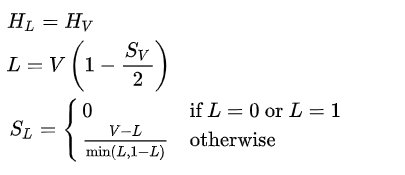

In [ ]:
src_hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
src_hsl = hsv_to_hsl(src_hsv)

In [ ]:
plt.imshow(src_hsl[:,:,0])
plt.colorbar()